In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pylab

from scipy.optimize import curve_fit, leastsq

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_style('whitegrid')

import covid19_module

In [2]:
df_cases_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col=False)
df_deaths_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col=False)
df_recoveries_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", index_col=False)
df_population_raw = pd.read_csv("./data/population_data/API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv")
#df_cases_raw.head()

In [3]:
df_cases = covid19_module.preprocess_frame(df_cases_raw)
df_deaths = covid19_module.preprocess_frame(df_deaths_raw)
df_recoveries = covid19_module.preprocess_frame(df_recoveries_raw)
df_population = df_population_raw[["Country Name", "2018"]]
#df_cases.head()

In [4]:
df_cases_grouped = df_cases_raw.groupby(by='Country/Region', as_index=False).agg('sum')
top_cases = df_cases_grouped.nlargest(10, df_cases_raw.columns[-1])['Country/Region']
print (top_cases)


print ("Mortality rates")
print ("---------------")
for country in top_cases:
    print (country, ": ", round(float(df_deaths[country].iloc[-1])/float(df_cases[country].iloc[-1])*100, 3), "%")
    
    
print ("\nPopulation percentage infected")
print ("---------------")
for country in top_cases:
    country_pop = country
    if country == "US":
        country_pop = "United States"
    if country == "Iran":
        country_pop = "Iran, Islamic Rep."
    if country == "Korea, South":
        country_pop = "Korea, Rep."
    print (country, 
    ": ", round(float(df_cases[country].iloc[-1])/float(df_population[df_population["Country Name"]==country_pop]["2018"])*100, 3), "%")

print ("\nPopulation permil dead")
print ("---------------")
for country in top_cases:
    country_pop = country
    if country == "US":
        country_pop = "United States"
    if country == "Iran":
        country_pop = "Iran, Islamic Rep."
    if country == "Korea, South":
        country_pop = "Korea, Rep."
    print (country, ": ", round(float(df_deaths[country].iloc[-1])/float(df_population[df_population["Country Name"]==country_pop]["2018"])*1000, 5), "permil")

166                US
83              Italy
151             Spain
35              China
64            Germany
60             France
79               Iran
170    United Kingdom
156       Switzerland
16            Belgium
Name: Country/Region, dtype: object
Mortality rates
---------------
US :  1.84 %
Italy :  11.393 %
Spain :  8.773 %
China :  4.024 %
Germany :  0.964 %
France :  6.708 %
Iran :  6.644 %
United Kingdom :  6.284 %
Switzerland :  2.255 %
Belgium :  4.311 %

Population percentage infected
---------------
US :  0.049 %
Italy :  0.168 %
Spain :  0.188 %
China :  0.006 %
Germany :  0.081 %
France :  0.067 %
Iran :  0.051 %
United Kingdom :  0.034 %
Switzerland :  0.187 %
Belgium :  0.104 %

Population permil dead
---------------
US :  0.0091 permil
Italy :  0.1918 permil
Spain :  0.16514 permil
China :  0.00238 permil
Germany :  0.00778 permil
France :  0.04523 permil
Iran :  0.0337 permil
United Kingdom :  0.02122 permil
Switzerland :  0.04215 permil
Belgium :  0.04491 permil

In [5]:
#df_cases_reference = df_cases.copy()
covid19_module.shift_to_day_zero(df_cases, df_cases)
covid19_module.shift_to_day_zero(df_deaths, df_deaths)
covid19_module.shift_to_day_zero(df_recoveries, df_recoveries)

<IPython.core.display.Javascript object>


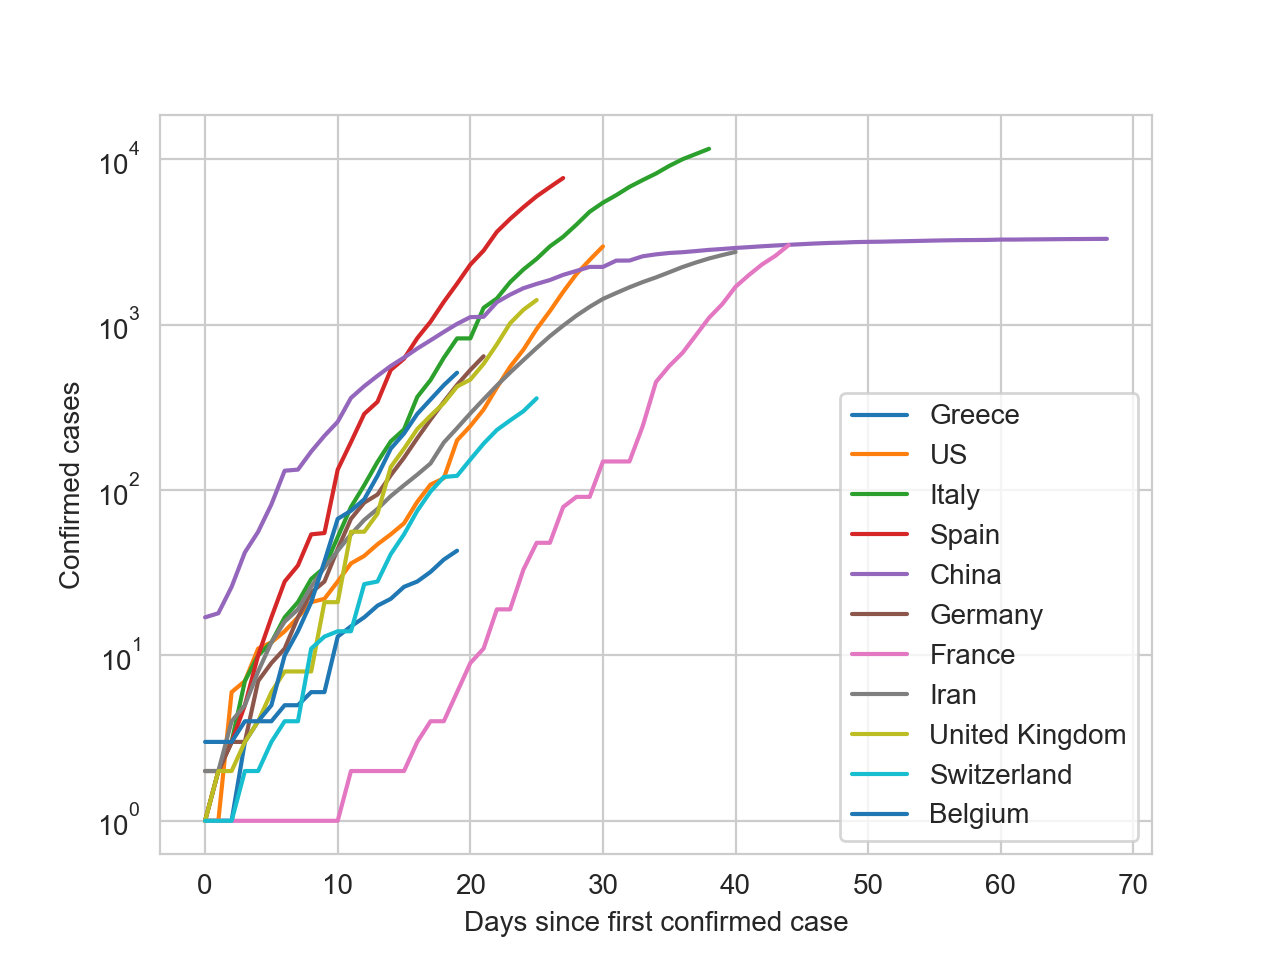

In [7]:
%matplotlib notebook

countries = top_cases
covid19_module.plot_confirmed_cases(df_deaths, countries)

In [ ]:
%matplotlib notebook

covid19_module.plot_case_death_recovery('China', df_cases, df_deaths, df_recoveries)
covid19_module.plot_case_death_recovery('notChina', df_cases, df_deaths, df_recoveries)

<IPython.core.display.Javascript object>


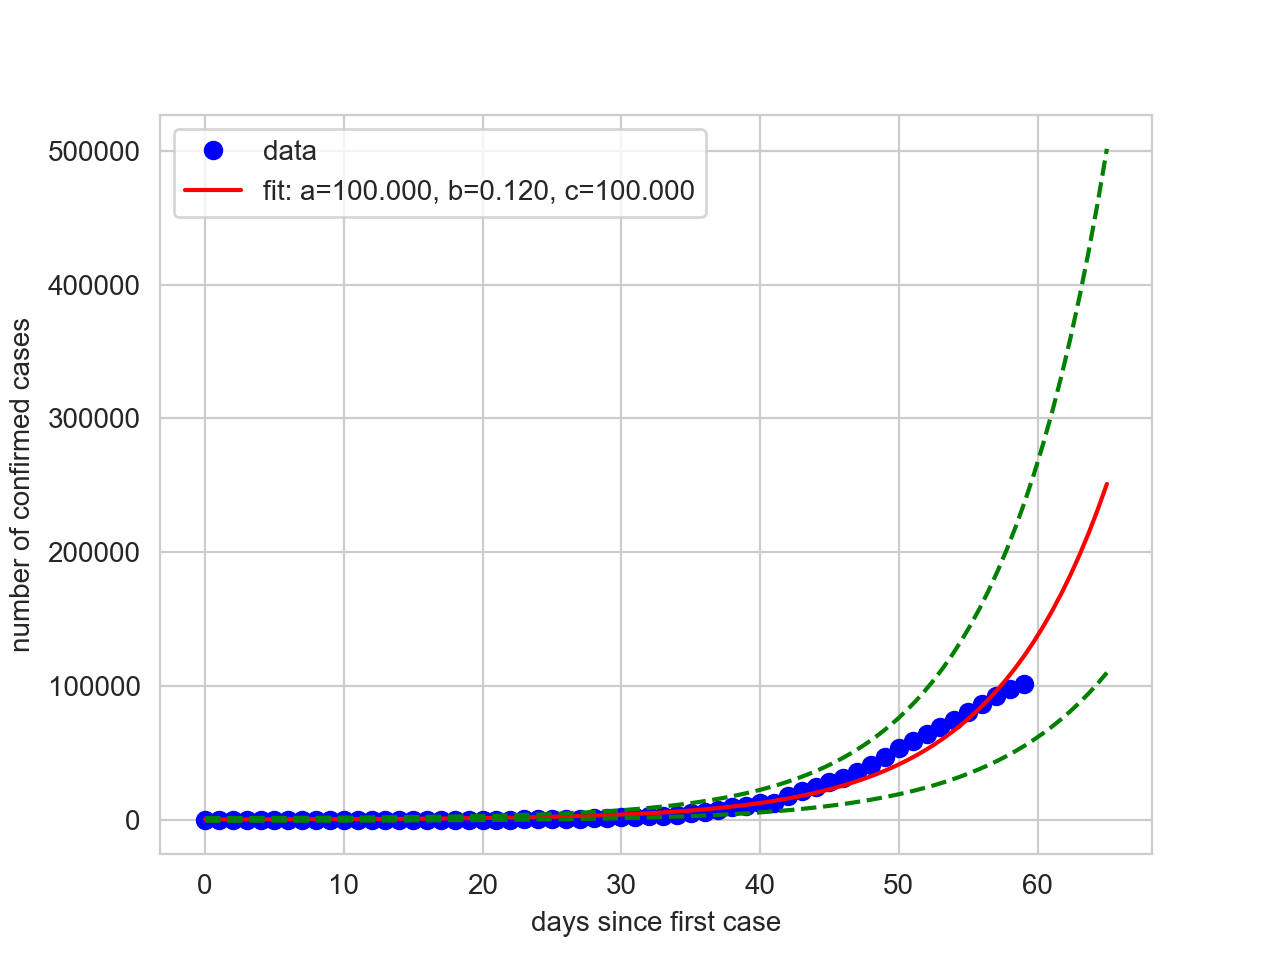

[100.           0.12042737 100.        ]
covariance matrix
[[ 1.19280245e+03 -2.08689651e-01 -2.21194976e+04]
 [-2.08689651e-01  3.66790894e-05  3.71671005e+00]
 [-2.21194976e+04  3.71671005e+00  1.00534207e+06]]


In [11]:
%matplotlib notebook

covid19_module.fit_cases_data("Italy", df_cases)

In [15]:
def sigmoid(x, x0, k, a, c):
    return (a / (1 + b*np.exp(-x-x0))) + c

def fit_cases_data_sigmoid(country, func, df):
    firstday = 0
    lastday = df[country].dropna().shape[0]

    xdata = df['Day'][(df['Day']>=firstday) & (df['Day']<lastday)]
    ydata = df[country][(df['Day']>=firstday) & (df['Day']<lastday)]
    
    plt.plot(xdata, ydata, 'bo', label='data')

    popt, pcov = curve_fit(func, xdata, ydata, [50.0, 0, -1e3, 1e3])
    print(popt)
    print("covariance matrix")
    print(pcov)
    x = np.linspace(firstday, lastday+10 , 100)
    plt.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

    perr=np.sqrt(np.diag(pcov)) #standard errors
    #plt.plot(x,func(x, *popt+perr), 'g')
    #plt.plot(x,func(x, *popt-perr), 'g')

    plt.xlabel('days since first case')
    plt.ylabel('number of confirmed cases')
    plt.legend()
    #plt.yscale('log')
    plt.show()

<IPython.core.display.Javascript object>


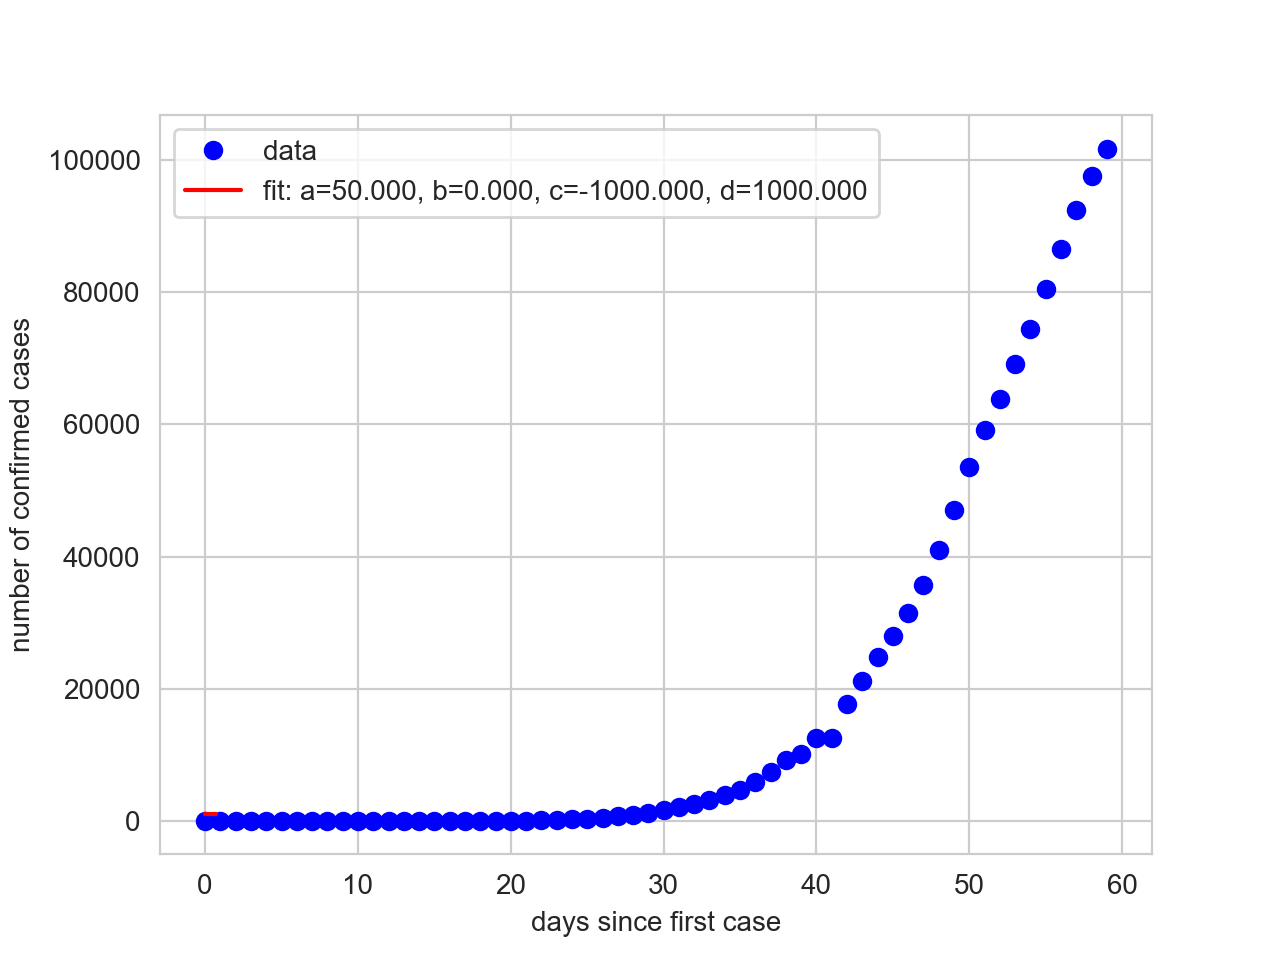

[   50.     0. -1000.  1000.]
covariance matrix
[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]


/Users/dimitris/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dimitris/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/dimitris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/dimitris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [16]:
%matplotlib notebook

fit_cases_data_sigmoid("Italy", sigmoid, df_cases)

In [ ]:
%matplotlib notebook
interval = 7
covid19_module.plot_daily_vs_total(df_cases, "China", interval)
covid19_module.plot_daily_vs_total(df_cases, "Korea, South", interval)
covid19_module.plot_daily_vs_total(df_cases, "Greece", interval)
covid19_module.plot_daily_vs_total(df_cases, "US", interval)
covid19_module.plot_daily_vs_total(df_cases, "Italy", interval)
covid19_module.plot_daily_vs_total(df_cases, "Spain", interval)
covid19_module.plot_daily_vs_total(df_cases, "Sweden", interval)
